<a href="https://colab.research.google.com/github/amirnafisa/Food101/blob/master/InceptionFood101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
# Install pytorch and tqdm (if necessary)
!pip install torch
!pip install torchvision
!pip install tqdm

!pip install Pillow==4.0.0
!pip install PIL
!pip install image

  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [2]:
# Mount your google drive as the data drive
# This will require google authorization
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Handle imports

import math
import os
import datetime
import csv
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import tqdm
import torchvision.models as models

from IPython import display

import torch.utils.data as TUdata

import PIL
from PIL import Image
import os
import os.path
import numpy as np
from collections import defaultdict

from sklearn.metrics import confusion_matrix

In [0]:

def default_loader(path):
	return Image.open(path).convert('RGB')

class FOOD101(TUdata.Dataset):
    def __init__(self, root, list_IDs, labels, transform=None):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.data_dir = os.path.join(root,'food101/images/')
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label ##example drive/My Drive/cs482/DLProject/food101/apple_pie/xxxxx.jpg
        img = default_loader(self.data_dir + ID[0] + '/' + ID[1] + '.jpg')
        if self.transform is not None:
            X = self.transform(img)
        y = self.labels[ID[0]]

        return X, y

In [0]:
def partition_data_and_index_labels(data_dir, dataset, classes_txt, train_txt, test_txt):
    labels_file = os.path.join(data_dir,dataset,classes_txt)
    labels = {}
    '''labels -> {apple_pie : 0, fish_and_chips : ...}'''
    with open(labels_file,'r') as rf:
        for idx, line in enumerate(rf.readlines()):
            line = line.strip()
            line = line
            labels[line] = idx
    
    train_file = os.path.join(data_dir,dataset,train_txt)
    test_file = os.path.join(data_dir,dataset,test_txt)
    partition = defaultdict(list)
    
    '''partition -> {'train : [[apple_pie, xxxxx.jpg], [apple_pie, xxyyyy.jpg], 
    [fish_and_chips, aaaabb.jpg]], test: [[apple_pie, abcdabcd.jpg]]}}'''
    
    with open(train_file,'r') as rf:
        for idx, line in enumerate(rf.readlines()):
            line = line.strip()
            ID = line.split('/')
            partition['train'].append([ID[0], ID[1]])
        

    with open(test_file,'r') as rf:
        for idx, line in enumerate(rf.readlines()):
            line = line.strip()
            ID = line.split('/')
            partition['test'].append([ID[0], ID[1]])
            
    return partition, labels

In [0]:
# Generators
def prepare_dataset(args):
    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
    
    
    train_dataset = FOOD101(args.data_dir, args.partition['train'], args.labels, transform=transforms.Compose([transforms.RandomResizedCrop(args.resolution),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                               ]))


    train_loader = TUdata.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)


    test_dataset = FOOD101(args.data_dir, args.partition['test'], args.labels, transform=transforms.Compose([transforms.RandomResizedCrop(args.resolution),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                               ]))

    test_loader = TUdata.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
    
    
    def time_stamp(fname, fmt='%m-%d-%H-%M_{fname}'):
        return datetime.datetime.now().strftime(fmt).format(fname=fname)
        
    training_run_name = time_stamp(args.dataset + '_' + args.name)
    training_run_dir = os.path.join(args.data_dir, 'run_dir', training_run_name)
    
    if not os.path.exists(training_run_dir):
        os.makedirs(training_run_dir)
    
    return train_loader, test_loader, train_dataset, test_dataset, training_run_dir

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def cm_analysis(y_true, y_pred, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    labels=map(str, range(9 + 1))
    labels_file = os.path.join(args.data_dir,args.dataset,args.classes_txt)
    ymap = {}
    '''labels -> {apple_pie : 0, fish_and_chips : 4}'''
    with open(labels_file,'r') as rf:
        for idx, line in enumerate(rf.readlines()):
            line = line.strip()
            line = line
            ymap[idx] = line
    if ymap is not None:
        y_pred = [ymap[np.int(yi)] for yi in y_pred]
        y_true = [ymap[np.int(yi)] for yi in y_true]
        labels = [ymap[np.int(yi)] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.show
    #plt.savefig(filename)

In [0]:
# The Args object will contain all of our parameters
# If you want to run with different arguments, create another Args object

class Args(object):
    def __init__(self, name='food101', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='adam', momentum=0.5,
            seed=1, log_interval=100, dataset='food101', n_categories=10,
            data_dir='drive/My Drive/cs482/DLProject/', model='inception',
            cuda=True):
        self.name = name # name for this training run. Don't use spaces.
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size # Input batch size for testing
        self.epochs = epochs # Number of epochs to train
        self.lr = lr # Learning rate
        self.optimizer = optimizer # sgd/p1sgd/adam/rms_prop
        self.momentum = momentum # SGD Momentum
        self.seed = seed # Random seed
        self.log_interval = log_interval # Batches to wait before logging
                                     # detailed status. 0 = never
        self.dataset = dataset # mnist/fashion_mnist
        self.data_dir = data_dir
        self.model = model # default/P2Q7DoubleChannelsNet/P2Q7HalfChannelsNet/
                  # P2Q8BatchNormNet/P2Q9DropoutNet/P2Q10DropoutBatchnormNet/
                  # P2Q11ExtraConvNet/P2Q12RemoveLayerNet/P2Q13UltimateNet
        self.resolution = 299 if self.model == 'inception' else 224
        self.cuda = cuda and torch.cuda.is_available()
        self.categories = n_categories
        if self.categories == 10:
            self.classes_txt = 'meta/C10.txt'
            self.train_txt = 'meta/train_C10.txt'
            self.test_txt = 'meta/test_C10.txt'
        else:
            self.classes_txt = 'meta/classes.txt'
            self.train_txt = 'meta/train.txt'
            self.test_txt = 'meta/test.txt'
        
        self.partition, self.labels = partition_data_and_index_labels(self.data_dir,self.dataset,self.classes_txt,self.train_txt,self.test_txt)


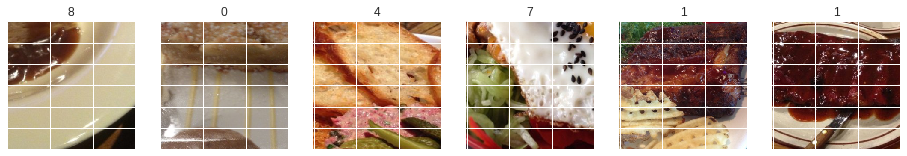

In [9]:
args = Args(model='inception',n_categories=10,epochs=20)
train_loader, test_loader, train_dataset, test_dataset, run_path = prepare_dataset(args)
# visualize some images
idx = torch.randint(0, 2500, (6,), dtype=torch.int)

images = [test_dataset[i] for i in idx]

fig, axes = plt.subplots(1,6,figsize=(16,20))
for axis, img in zip(axes, images):
    axis.imshow(img[0].permute(1,2,0))
    axis.set_title(img[1])
    axis.set_yticklabels([])
    axis.set_xticklabels([])
plt.show()




In [0]:
def train(model, optimizer, train_loader, epoch, total_minibatch_count,
        train_losses, train_accs):
    # Training for a full epoch

    model.train()
    correct_count, total_loss, total_acc = 0., 0., 0.
    progress_bar = tqdm.tqdm(train_loader, desc='Training')
    CEloss = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(progress_bar):

        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()

        # Forward prediction step
        #Inception model needs special handling: refer https://github.com/pytorch/vision/issues/302
        if args.model == 'inception':
            output,_ = model(data)
        else:
            output = model(data) 
        loss = CEloss(output, target)

        # Backpropagation step
        loss.backward()
        optimizer.step()

        # The batch has ended, determine the accuracy of the predicted outputs
        pred = output.data.max(1)[1]  

        # target labels and predictions are categorical values from 0 to 9.
        matches = target == pred
        accuracy = matches.float().mean()
        correct_count += matches.sum()

        if args.log_interval != 0 and \
                total_minibatch_count % args.log_interval == 0:

            train_losses.append(loss.data[0])
            train_accs.append(accuracy.data[0])
            
        total_loss += loss.data
        total_acc += accuracy.data
            
        progress_bar.set_description(
            'Epoch: {} loss: {:.4f}, acc: {:.2f}'.format(
                epoch, total_loss / (batch_idx + 1), total_acc / (batch_idx + 1)))
        #progress_bar.refresh()

        total_minibatch_count += 1

    return total_minibatch_count

In [0]:
def test(model, test_loader, epoch, total_minibatch_count,
        val_losses, val_accs):
    # Validation Testing
    model.eval()
    test_loss, correct = 0., 0.
    progress_bar = tqdm.tqdm(test_loader, desc='Validation')
    CEloss = nn.CrossEntropyLoss(reduction='sum')
    cum_pred=torch.LongTensor([])
    cum_target=torch.LongTensor([])
    with torch.no_grad():
        for data, target in progress_bar:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data) 
            test_loss += CEloss(output, target).data  # sum up batch loss
            pred = output.data.max(1)[1]  # get the index of the max log-probability
            cum_pred= torch.cat((cum_pred, pred.cpu()))
            cum_target=torch.cat((cum_target, target.cpu()))
            correct += (target == pred).float().sum()
    confusion=confusion_matrix(cum_target.cpu().numpy(),cum_pred.cpu().numpy())
    
    print('\nConfusion_matrix:\n', confusion)
    
    if epoch==args.epochs:
        cm_analysis(cum_target, cum_pred)
    
    test_loss /= len(test_loader.dataset)
    
    acc = correct / len(test_loader.dataset)

    val_losses.append(test_loss)
    val_accs.append(acc)
    
    progress_bar.clear()
    progress_bar.write(
        '\nEpoch: {} validation test results - Average val_loss: {:.4f}, val_acc: {}/{} ({:.2f}%)'.format(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    return acc

In [0]:
# Run the experiment
def run_experiment(args):

    total_minibatch_count = 0

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    train_loader, test_loader, _, _, run_path = prepare_dataset(args)

    
    epochs_to_run = args.epochs

    # Choose model
    # TODO add all the other models here if their parameter is specified
    if args.model == 'default' or args.model == 'P2Q7DefaultChannelsNet':
        model = Net()
    elif args.model == 'inception':
        model = models.inception_v3(pretrained=True)
    elif args.model == 'resnet':
        model = models.resnet18(pretrained=True)
    elif args.model in globals():
        model = globals()[args.model]()
    else:
        raise ValueError('Unknown model type: ' + args.model)

    if args.cuda:
        model.cuda()

    # Choose optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    elif args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif args.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters())
    else:
        raise ValueError('Unsupported optimizer: ' + args.optimizer)

    # Run the primary training loop, starting with validation accuracy of 0
    val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(1, epochs_to_run + 1):
        
        # train for 1 epoch
        total_minibatch_count = train(model, optimizer, train_loader,
                                    epoch, total_minibatch_count,
                                    train_losses, train_accs)
        # validate progress on test dataset
        val_acc = test(model, test_loader, epoch, total_minibatch_count,
                       val_losses, val_accs)
        
    fig, axes = plt.subplots(1,4, figsize=(13,4))
    # plot the losses and acc
    plt.title(args.name)
    axes[0].plot(train_losses)
    axes[0].set_title("Loss")
    axes[1].plot(train_accs)
    axes[1].set_title("Acc")
    axes[2].plot(val_losses)
    axes[2].set_title("Val loss")
    axes[3].plot(val_accs)
    axes[3].set_title("Val Acc")
    
    # Write to csv file
    with open(os.path.join(run_path + 'train.csv'), 'w') as f:
        csvw = csv.writer(f, delimiter=',')
        for loss, acc in zip(train_losses, train_accs):
            csvw.writerow((loss, acc))

    # Predict and Test
    images, labels = next(iter(test_loader))
    if args.cuda:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    predicted = torch.max(output, 1)[1]
    fig, axes = plt.subplots(1,6,figsize=(16,20))
    for i, (axis, img, lbl) in enumerate(zip(axes, images, predicted)):
        if i > 5:
            break
        img = img.permute(1,2,0).squeeze()
        axis.imshow(img)
        axis.set_title(lbl.data)
        axis.set_yticklabels([])
        axis.set_xticklabels([])
            


In [0]:
run_experiment(Args(model='inception',n_categories=10,epochs=20))

Training:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Epoch: 1 loss: 1.9750, acc: 0.43:  34%|███▍      | 40/118 [15:12<42:01, 32.32s/it]